# Exercise Word Embeddings


Train word embeddings and compare it.

## 1.&nbsp;Setup


In [ ]:
# Install WorldCloud
!pip install WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import packages
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.lang.en import English
from gensim.models import Word2Vec
import gensim.downloader as api
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import random
from pathlib import Path

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Default Style Settings
matplotlib.rcParams['figure.dpi'] = 300
pd.options.display.max_colwidth = 200

# Set preferences
sns.set(color_codes=True)
sns.set(font_scale=0.3)

In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##&nbsp;2. Import Data
Import of a dataset concerning hotel reviews on trip advisor\
Source: [Kaggle dataset "Trip Advisor Hotel Reviews"](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews)

In [ ]:
# Import data from google drive
data_folder = Path("/content/drive/MyDrive/Colab Notebooks/CTA/Exercise_2")
ta_reviews = data_folder / "tripadvisor_hotel_reviews.csv"

In [ ]:
# Inspect the data frame
df = pd.read_csv(ta_reviews)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 480.3+ KB


In [ ]:
# check the first rows
df.head(10)

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room...",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took...",2
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunct...,3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown shopping area, pet friendly room showed no signs animal hair smells, monaco suite sleeping area big s...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room huge staff helpful, booked hotels website seahawk package, no charge parking got voucher taxi, probl...",5
5,"love monaco staff husband stayed hotel crazy weekend attending memorial service best friend husband celebrating 12th wedding anniversary, talk mixed emotions, booked suite hotel monte carlos, loan...",5
6,"cozy stay rainy city, husband spent 7 nights monaco early january 2008. business trip chance come ride.we booked monte carlo suite proved comfortable longish stay, room 905 located street building...",5
7,"excellent staff, housekeeping quality hotel chocked staff make feel home, experienced exceptional service desk staff concierge door men maid service needs work, maid failed tuck sheets foot bed in...",4
8,"hotel stayed hotel monaco cruise, rooms generous decorated uniquely, hotel remodeled pacific bell building charm sturdiness, everytime walked bell men felt like coming home, secure, great single t...",5
9,"excellent stayed hotel monaco past w/e delight, reception staff friendly professional room smart comfortable bed, particularly liked reception small dog received staff guests spoke loved, mild neg...",5


## 3.&nbsp;Tokenization

In [ ]:
# Disable all the annotators except the tokenizer so its fast
nlp = English(disable=['tagger', 'parser', 'ner'])

# Only use lower case words because for similarity tasks distinguishing between e.g., "Hotel" and "hotel" isn't meaningful
def tokenize(text):
  return [t.text.lower() for t in nlp(text)]

In [ ]:
# Apply tokenization
df['tokens'] = df['Review'].apply(tokenize)
df.head()

,Review,Rating,tokens
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room...",4,"[nice, hotel, expensive, parking, got, good, deal, stay, hotel, anniversary, ,, arrived, late, evening, took, advice, previous, reviews, did, valet, parking, ,, check, quick, easy, ,, little, disa..."
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took...",2,"[ok, nothing, special, charge, diamond, member, hilton, decided, chain, shot, 20th, anniversary, seattle, ,, start, booked, suite, paid, extra, website, description, not, ,, suite, bedroom, bathro..."
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunct...,3,"[nice, rooms, not, 4, *, experience, hotel, monaco, seattle, good, hotel, n't, 4, *, level.positives, large, bathroom, mediterranean, suite, comfortable, bed, pillowsattentive, housekeeping, staff..."
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown shopping area, pet friendly room showed no signs animal hair smells, monaco suite sleeping area big s...",5,"[unique, ,, great, stay, ,, wonderful, time, hotel, monaco, ,, location, excellent, short, stroll, main, downtown, shopping, area, ,, pet, friendly, room, showed, no, signs, animal, hair, smells, ..."
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room huge staff helpful, booked hotels website seahawk package, no charge parking got voucher taxi, probl...",5,"[great, stay, great, stay, ,, went, seahawk, game, awesome, ,, downfall, view, building, did, n't, complain, ,, room, huge, staff, helpful, ,, booked, hotels, website, seahawk, package, ,, no, cha..."


##&nbsp;4. Fit Models
In this chapter three models will be trained to compare it afterwards. Two  models are trained by the author of this notebook with different window size, the third model is a pre-trained FastText model.

###&nbsp;4.1 Word2Vec Model I

According to the course script "3.1_train_your_clothing_space.ipynb" Word2Vec is  a neural network where the inputs are target words and the outputs are context words (skip-gram), or vice versa, when CBOW is used (given a context, we want to know which word is most likely to appear in it).

The following are the main parameters of the model:
* `sentences` - a list of the tokenized texts we will use
* `size` - the dimensionality of the word embedding (100 means each word is mapped to a 100 element vector). 300 seems to be the most popular choice for embeddings trained on massive datasets.
* `window` - the distance in number of words considered "in context" for a given target word. Larger windows (>5) result in embeddings that are more reflective of word meaning. Smaller windows result in embeddings that are more reflective of word syntax (how it is used in a sentence). For example, "good" and "bad" have opposite meaning but similar syntax, i.e. you can replace one with the other in most sentences without violating any grammatical rules.
* `sg` – training algorithm: 1 for skip-gram; otherwise CBOW.

In the first example the window is set to 5, which is the default value [Alammar, J., 2019](https://jalammar.github.io/illustrated-word2vec/).

In [ ]:
# Set values for various parameters
feature_size_I = 300  # Word vector dimensionality
window_context_I = 5  # Context window size
min_word_count_I = 5  # Minimum word count

w2vmodel_I = Word2Vec(sentences=df['tokens'], size=feature_size_I, window=window_context_I, min_count=min_word_count_I, sg = 0)

### 4.2&nbsp;Word2Vec Model II

For the second word2vec model the context window is enlarged to 15, which should result in embeddings that are more reflective of word meaning. The other parameters are kept the same.

In [ ]:
# Set values for various parameters
feature_size_II = 300  # Word vector dimensionality
window_context_II = 15  # Context window size
min_word_count_II = 5  # Minimum word count

w2vmodel_II = Word2Vec(sentences=df['tokens'], size=feature_size_II, window=window_context_II, min_count=min_word_count_II, sg = 0)

### 4.3&nbsp;Fasttext
FastText is an extension to Word2Vec by Facebook. It use n-grams (subwords) instead of single words, e.g. the tri-grams for the word apple is app, ppl, and ple. The word embedding vector for apple will be the sum of all these n-grams. This have the advantage that rare word can be better represented. Furthermore, in contrast to word2vec, Fasttext is able to handle words, which are out-of-vocabulary [(Towardsdatascience, 2018)](https://towardsdatascience.com/word-embedding-with-word2vec-and-fasttext-a209c1d3e12c).



In [ ]:
fasttext_model = api.load("fasttext-wiki-news-subwords-300")

## 5.&nbsp;ETA (short)
In this chapter a short exploratory text analysis is conducted to get an impression of the important and most frequent words.


### 5.1&nbsp;Most frequent words

Text(0.5, 1.0, '10 most frequent words')

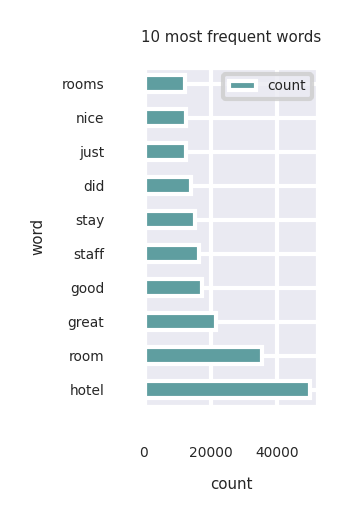

In [ ]:
# Definition of function
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus) # exclude stopwords
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get top 10 frequent words and store it as dataframe
top_words = get_top_n_words(df['Review'], 10)
unigrams_top_words = pd.DataFrame(top_words, columns = ['word' , 'count'])

# plot the results
unigrams_top_words.plot(kind='barh', x='word', color='cadetblue', width=0.5,figsize=(0.75,1.5))
plt.xlabel('count')
plt.ylabel('word')
plt.title('10 most frequent words')

The most frequent words seems to be meaningful, all can be related to hotels or other accomodation. It is noticeable that both "room" and "rooms" are included in the 10 most common words. This is also explainable, since guests have used several rooms or refer in the review not only to their own room, but to the premises of the hotel in general.

### 5.2&nbsp;Wordcloud

([], <a list of 0 Text major ticklabel objects>)

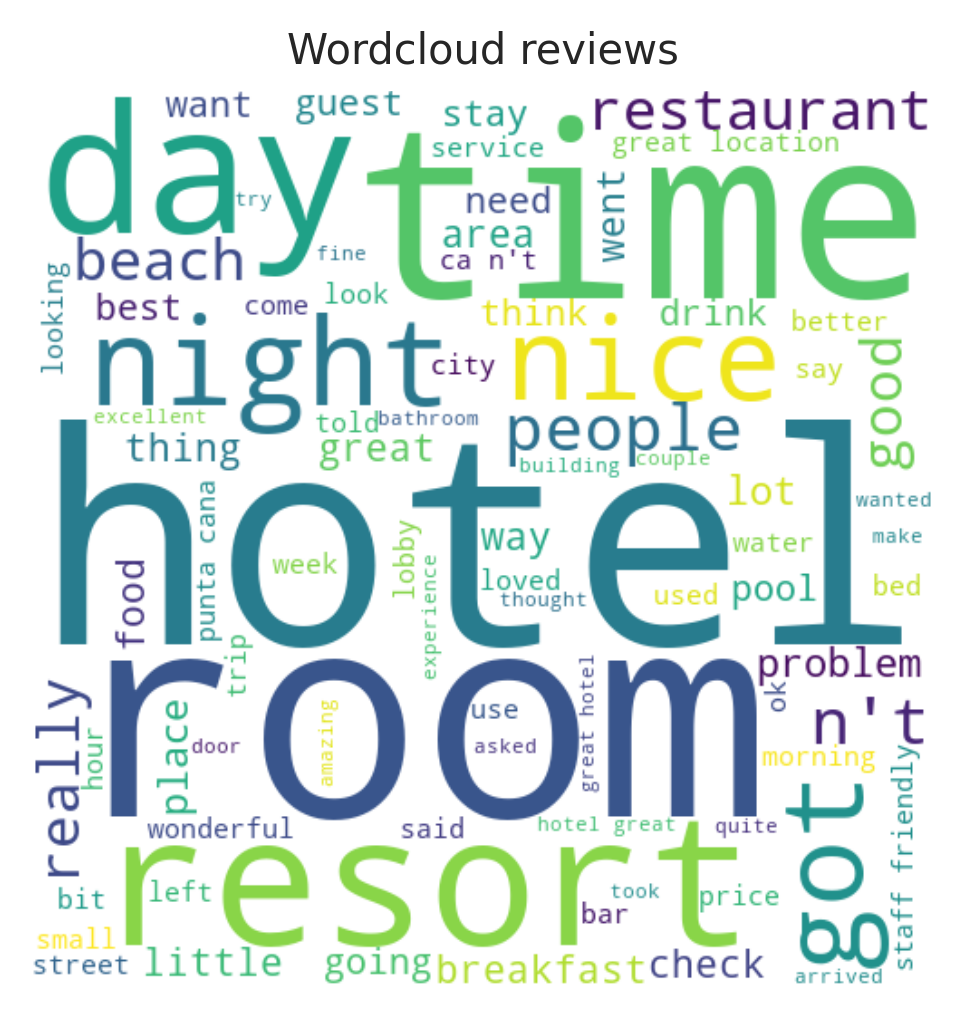

In [ ]:
# Get all reviews
all_reviews = df['Review']

# Concatenate strings in the Series/Index with cat() function to have all descriptions as a string
reviews_wc = all_reviews.str.cat()

# Word clouds for reviews
random.seed(13)
wordcloud_image = WordCloud(width = 500, height = 500,
                background_color ='white',
                min_font_size = 10).generate(reviews_wc)
plt.imshow(wordcloud_image,interpolation="bilinear",)
plt.title('Wordcloud reviews', fontsize=10)
plt.xticks([])
plt.yticks([])

Some of the 10 most common words are also very prominent in Wordcloud, for example "room", "hotel" and "nice". However, other words are also strongly highlighted, which are not among the 10 most common. Interestingly, some of them have to do with (day) time, such as "time", "day" and "night". At most, these words were used in the reviews to draw attention to special features of the hotels that are related to the time of day. In addition, "time" could also refer to the stay in the hotel.

## 6.&nbsp;Usage of the the embeddings

### 6.1&nbsp;Most Similar Words

Now we want want to find the most similar words and compare the results of the different models and the synonyms according to WordNet. The first word is the most frequent one in the analysed reviews: "hotel".



In [ ]:
# Word2Vec Model I
w2vmodel_I.wv.most_similar('hotel', topn=5)

[('accomodation', 0.5537833571434021),
 ('hotels', 0.5480931997299194),
 ('property', 0.5423867106437683),
 ('amsterdam', 0.5154578685760498),
 ('accommodation', 0.5087258815765381)]

In [ ]:
# Word2Vec model II
w2vmodel_II.wv.most_similar('hotel', topn=5)

[('centrally', 0.5972995758056641),
 ('amsterdam', 0.5441858172416687),
 ('orchard', 0.5320600271224976),
 ('london', 0.5280190706253052),
 ('conveniently', 0.5251127481460571)]

In [ ]:
# Fasttext model
fasttext_model.wv.most_similar('hotel', topn=5)

<ipython-input-96-5d8066e7c247>:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  fasttext_model.wv.most_similar('hotel', topn=5)


[('hotel-', 0.831538200378418),
 ('hotels', 0.8100998997688293),
 ('hotel-restaurant', 0.7739641070365906),
 ('hotel.', 0.7615983486175537),
 ('non-hotel', 0.7609246969223022)]

In [ ]:
# WordNet
synonyms = []

for syn in wordnet.synsets("hotel"):
    for l in syn.lemmas():
        synonyms.append(l.name())

print(set(synonyms))

{'hotel'}


The second word is not a noun, but a very frequent used adjective in reviews: "great".

In [ ]:
# Word2Vec Model I
w2vmodel_I.wv.most_similar('great', topn=5)

[('fantastic', 0.8457933664321899),
 ('excellent', 0.8111850023269653),
 ('terrific', 0.7930687069892883),
 ('good', 0.7784805297851562),
 ('perfect', 0.7615659236907959)]

In [ ]:
# Word2Vec model II
w2vmodel_II.wv.most_similar('great', topn=5)

[('fantastic', 0.7747827768325806),
 ('terrific', 0.7554448843002319),
 ('excellent', 0.7408181428909302),
 ('perfect', 0.7204415798187256),
 ('good', 0.713753342628479)]

In [ ]:
# Fasttext model
fasttext_model.wv.most_similar('great', topn=5)

<ipython-input-100-e703b0e6865b>:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  fasttext_model.wv.most_similar('great', topn=5)


[('tremendous', 0.8364686369895935),
 ('terrific', 0.8169177770614624),
 ('wonderful', 0.7983270883560181),
 ('greate', 0.7961226105690002),
 ('greatest', 0.7910179495811462)]

In [ ]:
# WordNet
synonyms = []

for syn in wordnet.synsets("great"):
    for l in syn.lemmas():
        synonyms.append(l.name())

print(set(synonyms))

{'enceinte', 'keen', 'cracking', 'great', 'expectant', 'majuscule', 'large', 'peachy', 'bang-up', 'slap-up', 'smashing', 'bully', 'groovy', 'outstanding', 'swell', 'heavy', 'not_bad', 'capital', 'corking', 'nifty', 'neat', 'big', 'dandy', 'with_child', 'gravid'}


The last word we want to compare is used often in hotel reviews and in other contexts as well: "staff".

In [ ]:
# Word2Vec Model I
w2vmodel_I.wv.most_similar('staff', topn=5)

[('staffs', 0.6992020606994629),
 ('employees', 0.6734147667884827),
 ('personnel', 0.6475261449813843),
 ('efficient', 0.5922343730926514),
 ('polite', 0.5887106657028198)]

In [ ]:
# Word2Vec model II
w2vmodel_II.wv.most_similar('staff', topn=5)

[('staffs', 0.7480292320251465),
 ('receptionists', 0.665616512298584),
 ('employees', 0.6542038321495056),
 ('personnel', 0.6514844298362732),
 ('extremely', 0.6321738958358765)]

In [ ]:
# Fasttext model
fasttext_model.wv.most_similar('staff', topn=5)

<ipython-input-104-a0ea00688785>:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  fasttext_model.wv.most_similar('staff', topn=5)


[('non-staff', 0.7948962450027466),
 ('personnel', 0.7792227864265442),
 ('staffs', 0.778321385383606),
 ('staffers', 0.7589037418365479),
 ('faculty', 0.7560908794403076)]

In [ ]:
# WordNet
synonyms = []

for syn in wordnet.synsets("staff"):
    for l in syn.lemmas():
        synonyms.append(l.name())

print(set(synonyms))

{'faculty', 'staff', 'stave'}


Although the FastText model delivers very similar results for the token "great" as the self-trained models, there are clear differences for the other two tokens. For example, in the FastText model for "hotel" and "staff" the most similar words are very close to the word to be compared (similar word stem). Probably the resulting words of the FastText model do not necessarily occur in the hotel reviews and are therefore not in the corpus of the pre-trained models, which is the reason that other words are listed in the self-trained models, which are less similar regarding the word stem.

Another reason for this could be that the usage and meaning of "great" in hotel reviews is not very different from other texts, while the other two words could be used in more different ways, especially "staff".

In addition, for "hotel" and "staff" the similarity ratings are remarkable lower for the self-trained models compared to the FastText model.

The wider window of model II compared with model I seems to be a little visible for "hotel", the results for the other two tokens are similar. Furthermore, the similarity ratings for model II tend to be lower than those of model I.

The results of the search for synonyms in WordNet are difficult to compare and deviate surprisingly strongly from the top similar words of the models from the author. While for "hotel" and "staff" only very few synonyms are shown, which show little agreement with the other results, the list for "great" is very extensive, with words that were not necessarily expected.

For showing the most similar words for more than one search token we can use the following code (example:

In [ ]:
similar_words_model_I = {
    search_term:
    [item[0] for item in w2vmodel_I.wv.most_similar([search_term], topn=5)]
    for search_term in ['room', 'nice', 'resort', 'time']
}

similar_words_model_I

{'room': ['rooms', 'suite', 'double', 'king', 'apartment'],
 'nice': ['lovely', 'neat', 'great', 'nice.the', 'decent'],
 'resort': ['property', 'resorts', 'bavaro', 'vacation', 'beach'],
 'time': ['chance', 'week', 'vacation', 'longer', 'money']}

In [ ]:
similar_words_model_II = {
    search_term:
    [item[0] for item in w2vmodel_II.wv.most_similar([search_term], topn=5)]
    for search_term in ['room', 'nice', 'resort', 'time']
}

similar_words_model_II

{'room': ['rooms', 'room.the', 'cramped', 'balcony', 'suite'],
 'nice': ['great', 'big', 'decent', 'good', 'lovely'],
 'resort': ['resorts', 'bavaro', 'paradisus', 'vacation', 'beaches'],
 'time': ['longer', 'week', 'chance', 'vacation', 'day']}

In [ ]:
similar_words_ft = {
    search_term:
    [item[0] for item in fasttext_model.wv.most_similar([search_term], topn=5)]
    for search_term in ['room', 'nice', 'resort', 'time']
}

similar_words_ft

<ipython-input-108-cd7f2d0f930d>:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  [item[0] for item in fasttext_model.wv.most_similar([search_term], topn=5)]


{'room': ['rooms', 'room-', 'dayroom', 'hallway', 'hall'],
 'nice': ['nice-', 'lovely', 'nice-looking', 'nice-nice', 'wonderful'],
 'resort': ['resorts',
  'ski-resort',
  'mega-resort',
  'resort-style',
  'resort-like'],
 'time': ['moment', 'time-and', 'time--and', 'time--even', 'time.3']}

Further analysis confirms the results of the first. Tokens such as "nice" have similar meaning and usage in most cases and generate similar results for all models. Words like "time", on the other hand, are used differently in hotel reviews than in other texts, therefore the results of the self-trained models and the pre-trained models differ. The results of the two self-trained models are very similar.

### 6.2&nbsp;Calculate Similarity

In the next step the similarity between two words are computed and the results of the different models compared. First a check if the word order is important:

In [ ]:
word_I = 'breakfast'
word_II = 'nice'

sim_w2v_I = w2vmodel_I.wv.similarity(word_I, word_II)
sim_w2v_II = w2vmodel_II.wv.similarity(word_I, word_II)
sim_ft = fasttext_model.wv.similarity(word_I, word_II)
print('W2V model I: '+ str(sim_w2v_I))
print('W2V model II: '+ str(sim_w2v_II))
print('Fasttext model: '+ str(sim_ft))

W2V model I: 0.15924795
W2V model II: 0.11199724
Fasttext model: 0.39142025


<ipython-input-109-da5555e998fc>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  sim_ft = fasttext_model.wv.similarity(word_I, word_II)


In [ ]:
word_I = 'nice'
word_II = 'breakfast'

sim_w2v_I = w2vmodel_I.wv.similarity(word_I, word_II)
sim_w2v_II = w2vmodel_II.wv.similarity(word_I, word_II)
sim_ft = fasttext_model.wv.similarity(word_I, word_II)
print('W2V model I: '+ str(sim_w2v_I))
print('W2V model II: '+ str(sim_w2v_II))
print('Fasttext model: '+ str(sim_ft))

W2V model I: 0.15924795
W2V model II: 0.11199724
Fasttext model: 0.39142025


<ipython-input-110-6db2b76d833d>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  sim_ft = fasttext_model.wv.similarity(word_I, word_II)


We can conclude, that the word order in the function is not important.

In [ ]:
word_I = 'hotel'
word_II = 'room'

sim_w2v_I = w2vmodel_I.wv.similarity(word_I, word_II)
sim_w2v_II = w2vmodel_II.wv.similarity(word_I, word_II)
sim_ft = fasttext_model.wv.similarity(word_I, word_II)
print('W2V model I: '+ str(sim_w2v_I))
print('W2V model II: '+ str(sim_w2v_II))
print('Fasttext model: '+ str(sim_ft))

W2V model I: 0.3019608
W2V model II: 0.2179143
Fasttext model: 0.6251188


<ipython-input-111-746afbc55467>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  sim_ft = fasttext_model.wv.similarity(word_I, word_II)


In [ ]:
word_I = 'room'
word_II = 'great'

sim_w2v_I = w2vmodel_I.wv.similarity(word_I, word_II)
sim_w2v_II = w2vmodel_II.wv.similarity(word_I, word_II)
sim_ft = fasttext_model.wv.similarity(word_I, word_II)
print('W2V model I: '+ str(sim_w2v_I))
print('W2V model II: '+ str(sim_w2v_II))
print('Fasttext model: '+ str(sim_ft))

W2V model I: 0.05688502
W2V model II: -0.03340487
Fasttext model: 0.3724739


<ipython-input-112-791648155c8d>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  sim_ft = fasttext_model.wv.similarity(word_I, word_II)


In [ ]:
word_I = 'hotel'
word_II = 'location'

sim_w2v_I = w2vmodel_I.wv.similarity(word_I, word_II)
sim_w2v_II = w2vmodel_II.wv.similarity(word_I, word_II)
sim_ft = fasttext_model.wv.similarity(word_I, word_II)
print('W2V model I: '+ str(sim_w2v_I))
print('W2V model II: '+ str(sim_w2v_II))
print('Fasttext model: '+ str(sim_ft))

W2V model I: 0.40235844
W2V model II: 0.47483715
Fasttext model: 0.5133773


<ipython-input-113-86d105181843>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  sim_ft = fasttext_model.wv.similarity(word_I, word_II)


In [ ]:
word_I = 'hotel'
word_II = 'lobby'

sim_w2v_I = w2vmodel_I.wv.similarity(word_I, word_II)
sim_w2v_II = w2vmodel_II.wv.similarity(word_I, word_II)
sim_ft = fasttext_model.wv.similarity(word_I, word_II)
print('W2V model I: '+ str(sim_w2v_I))
print('W2V model II: '+ str(sim_w2v_II))
print('Fasttext model: '+ str(sim_ft))

W2V model I: 0.20017056
W2V model II: 0.19425227
Fasttext model: 0.5714592


<ipython-input-114-12c9ca629814>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  sim_ft = fasttext_model.wv.similarity(word_I, word_II)


In [ ]:
word_I = 'excellent'
word_II = 'bad'

sim_w2v_I = w2vmodel_I.wv.similarity(word_I, word_II)
sim_w2v_II = w2vmodel_II.wv.similarity(word_I, word_II)
sim_ft = fasttext_model.wv.similarity(word_I, word_II)
print('W2V model I: '+ str(sim_w2v_I))
print('W2V model II: '+ str(sim_w2v_II))
print('Fasttext model: '+ str(sim_ft))

W2V model I: 0.19571921
W2V model II: 0.0025436028
Fasttext model: 0.61476904


<ipython-input-115-12fa8f8a6e6c>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  sim_ft = fasttext_model.wv.similarity(word_I, word_II)


Somewhat surprisingly for the author, the FastText model provides the highest rating for similarity for every word combination examined, sometimes by a large margin. While this was to be expected for the word pair "excellent" and "bathroom", since these words are not particularly hotel review specific, other combinations such as "hotel" and "lobby", where "lobby" is a word that is not only used in the hotel context, showed different results. Especially the big differences in the ratings are surprising, only for "hotel" and "location" the ratings were relatively close to each other.

Since already in chapter 6.1 lower similarity ratings for the self-trained models could be observed, this could indicate that FastText generally calculates higher similarity values than the self-trained models. The reasons for this would have to be investigated further.

The results of model I and II are slightly different in each case; from the author's point of view, a clear pattern cannot be discerned in the words studied.

### 6.3&nbsp;Visualize embeddings
In this chapter we visualize the word embeddings. First of all, we take a sample of tokens and plot them according to their similarity.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


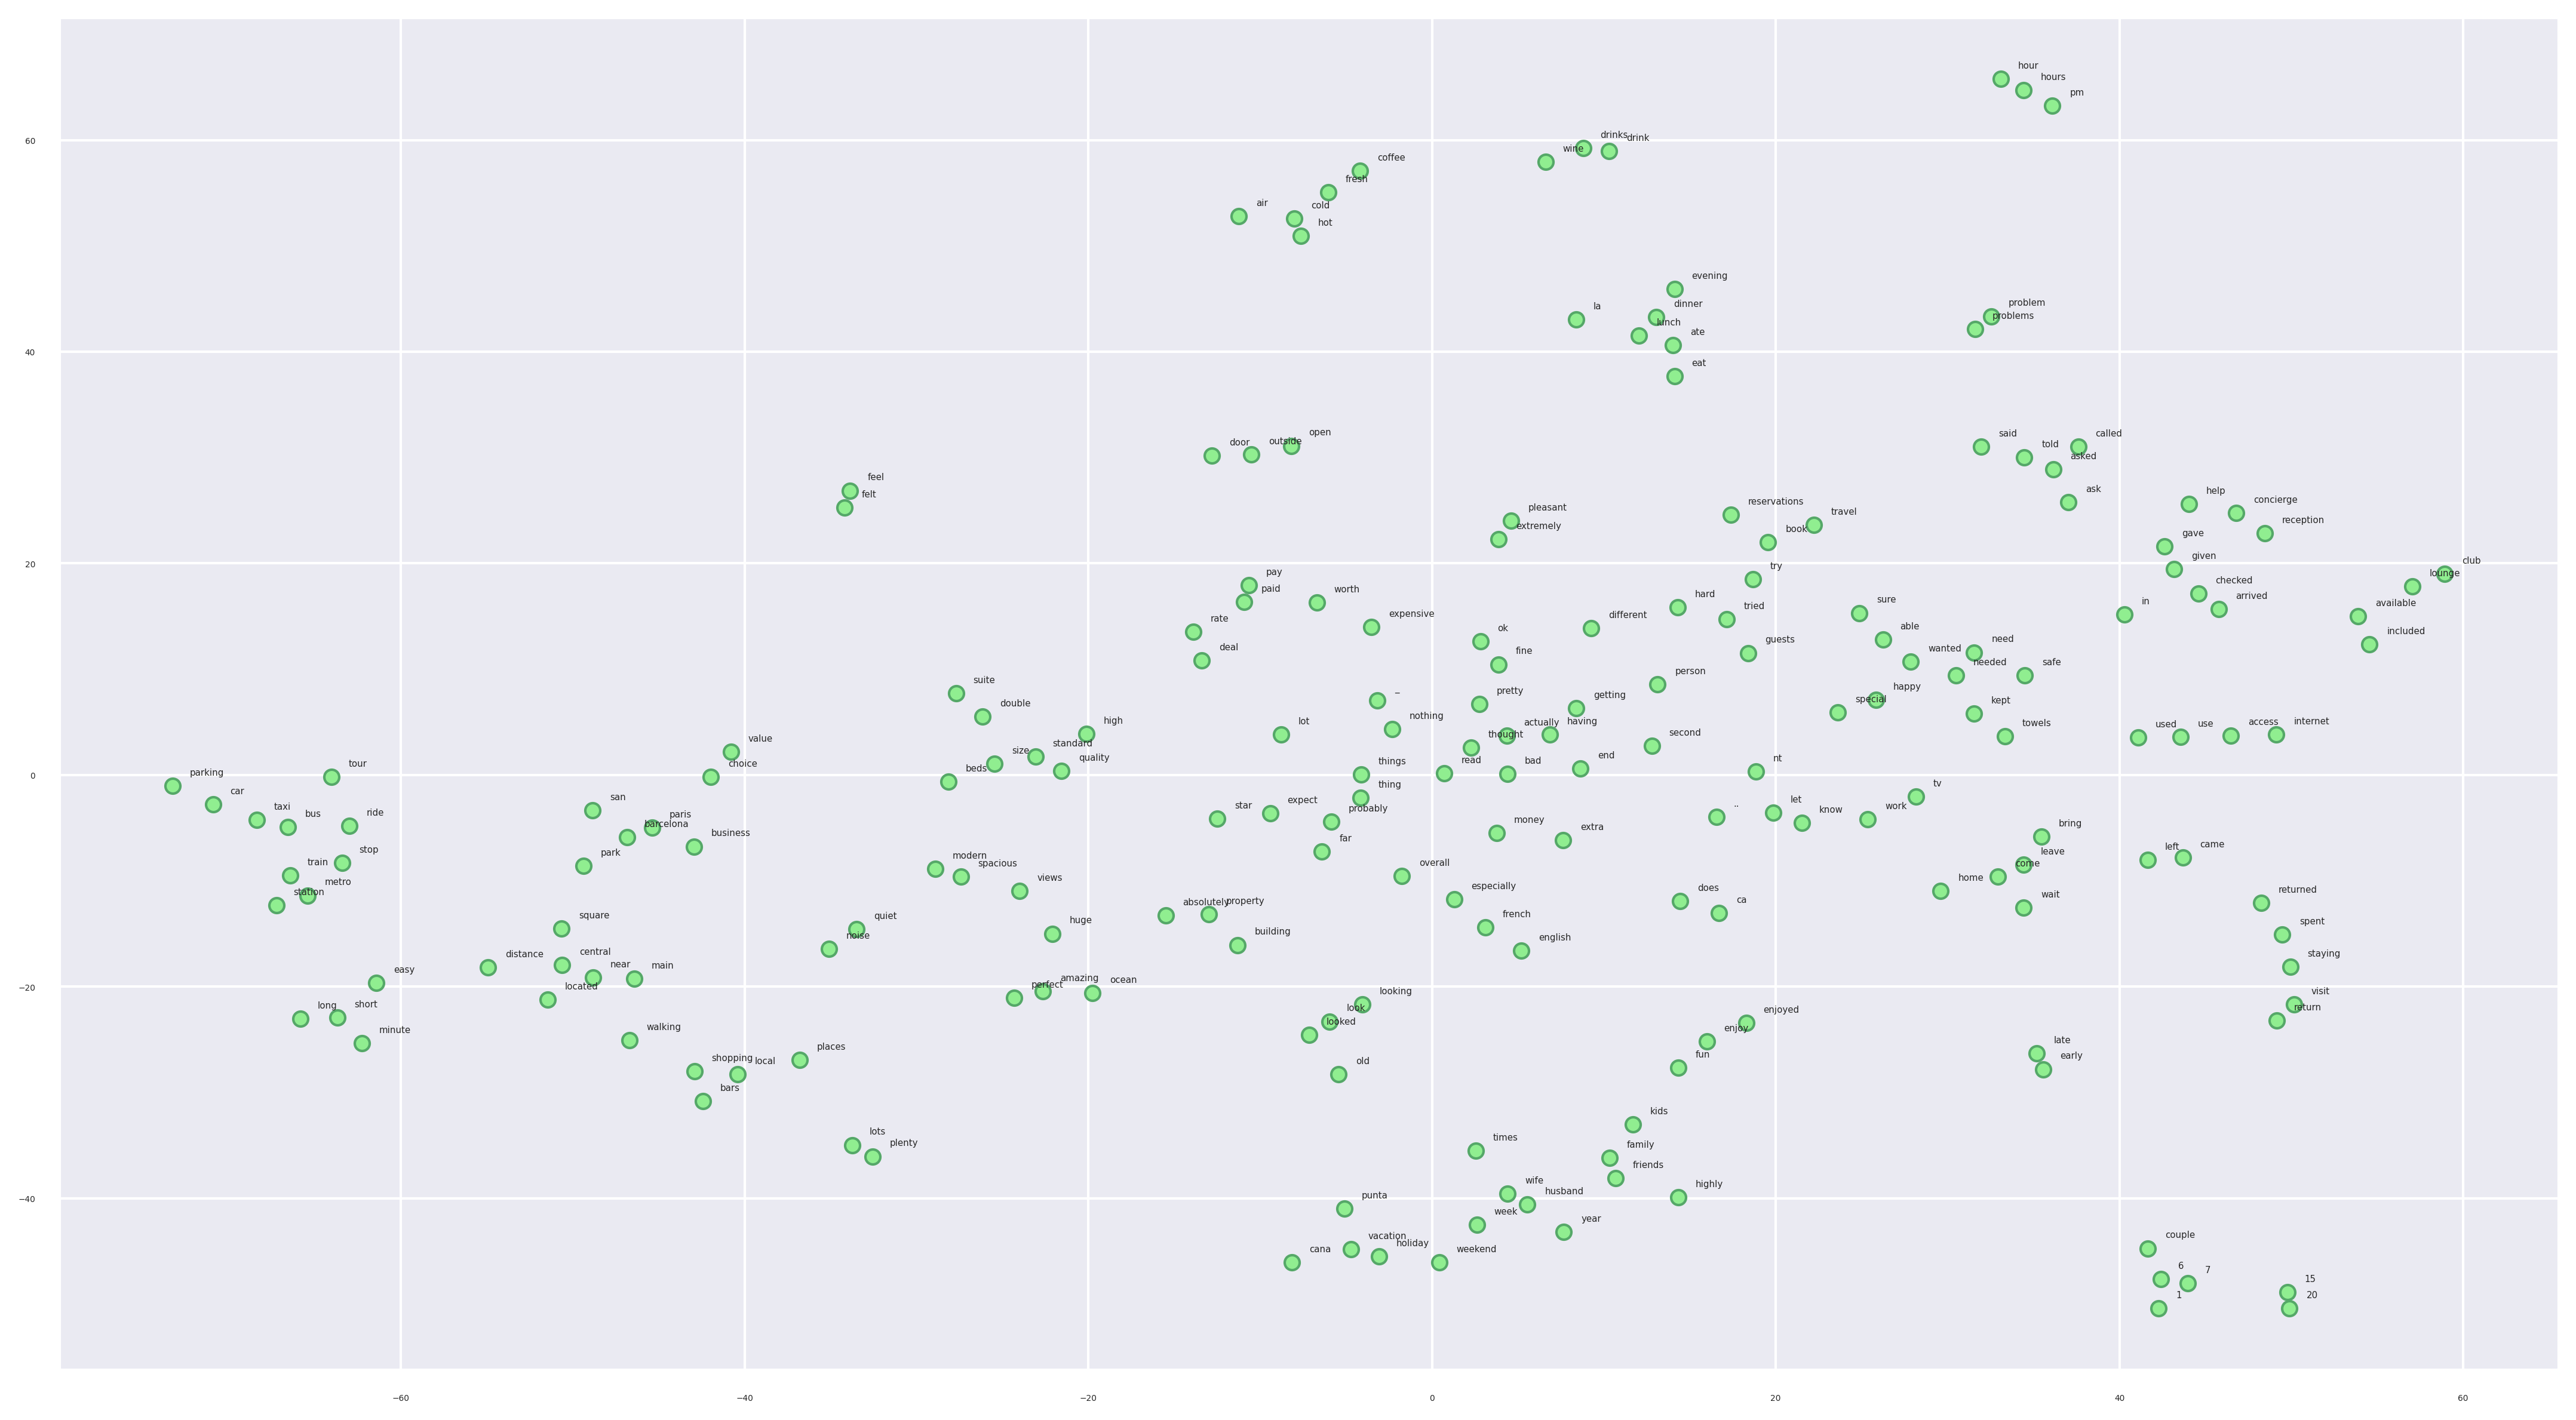

In [ ]:
words = w2vmodel_I.wv.index2word[100:300]      ## get the word forms of voculary sample
wvs = w2vmodel_I.wv[words]                     ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

In the plot are some groups/topics visible, for example:
- top left corner: transportation
- aeside: places, location
- bottom left corner: attributes of room/hotel
- top middle: duration / people
- middle: adjectives / feelings
- bottom middle: payment
- bottom middle-right: numbers
- middle right: reception / concierge
- bottom right: food and beverages

Now we do the same for model II.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


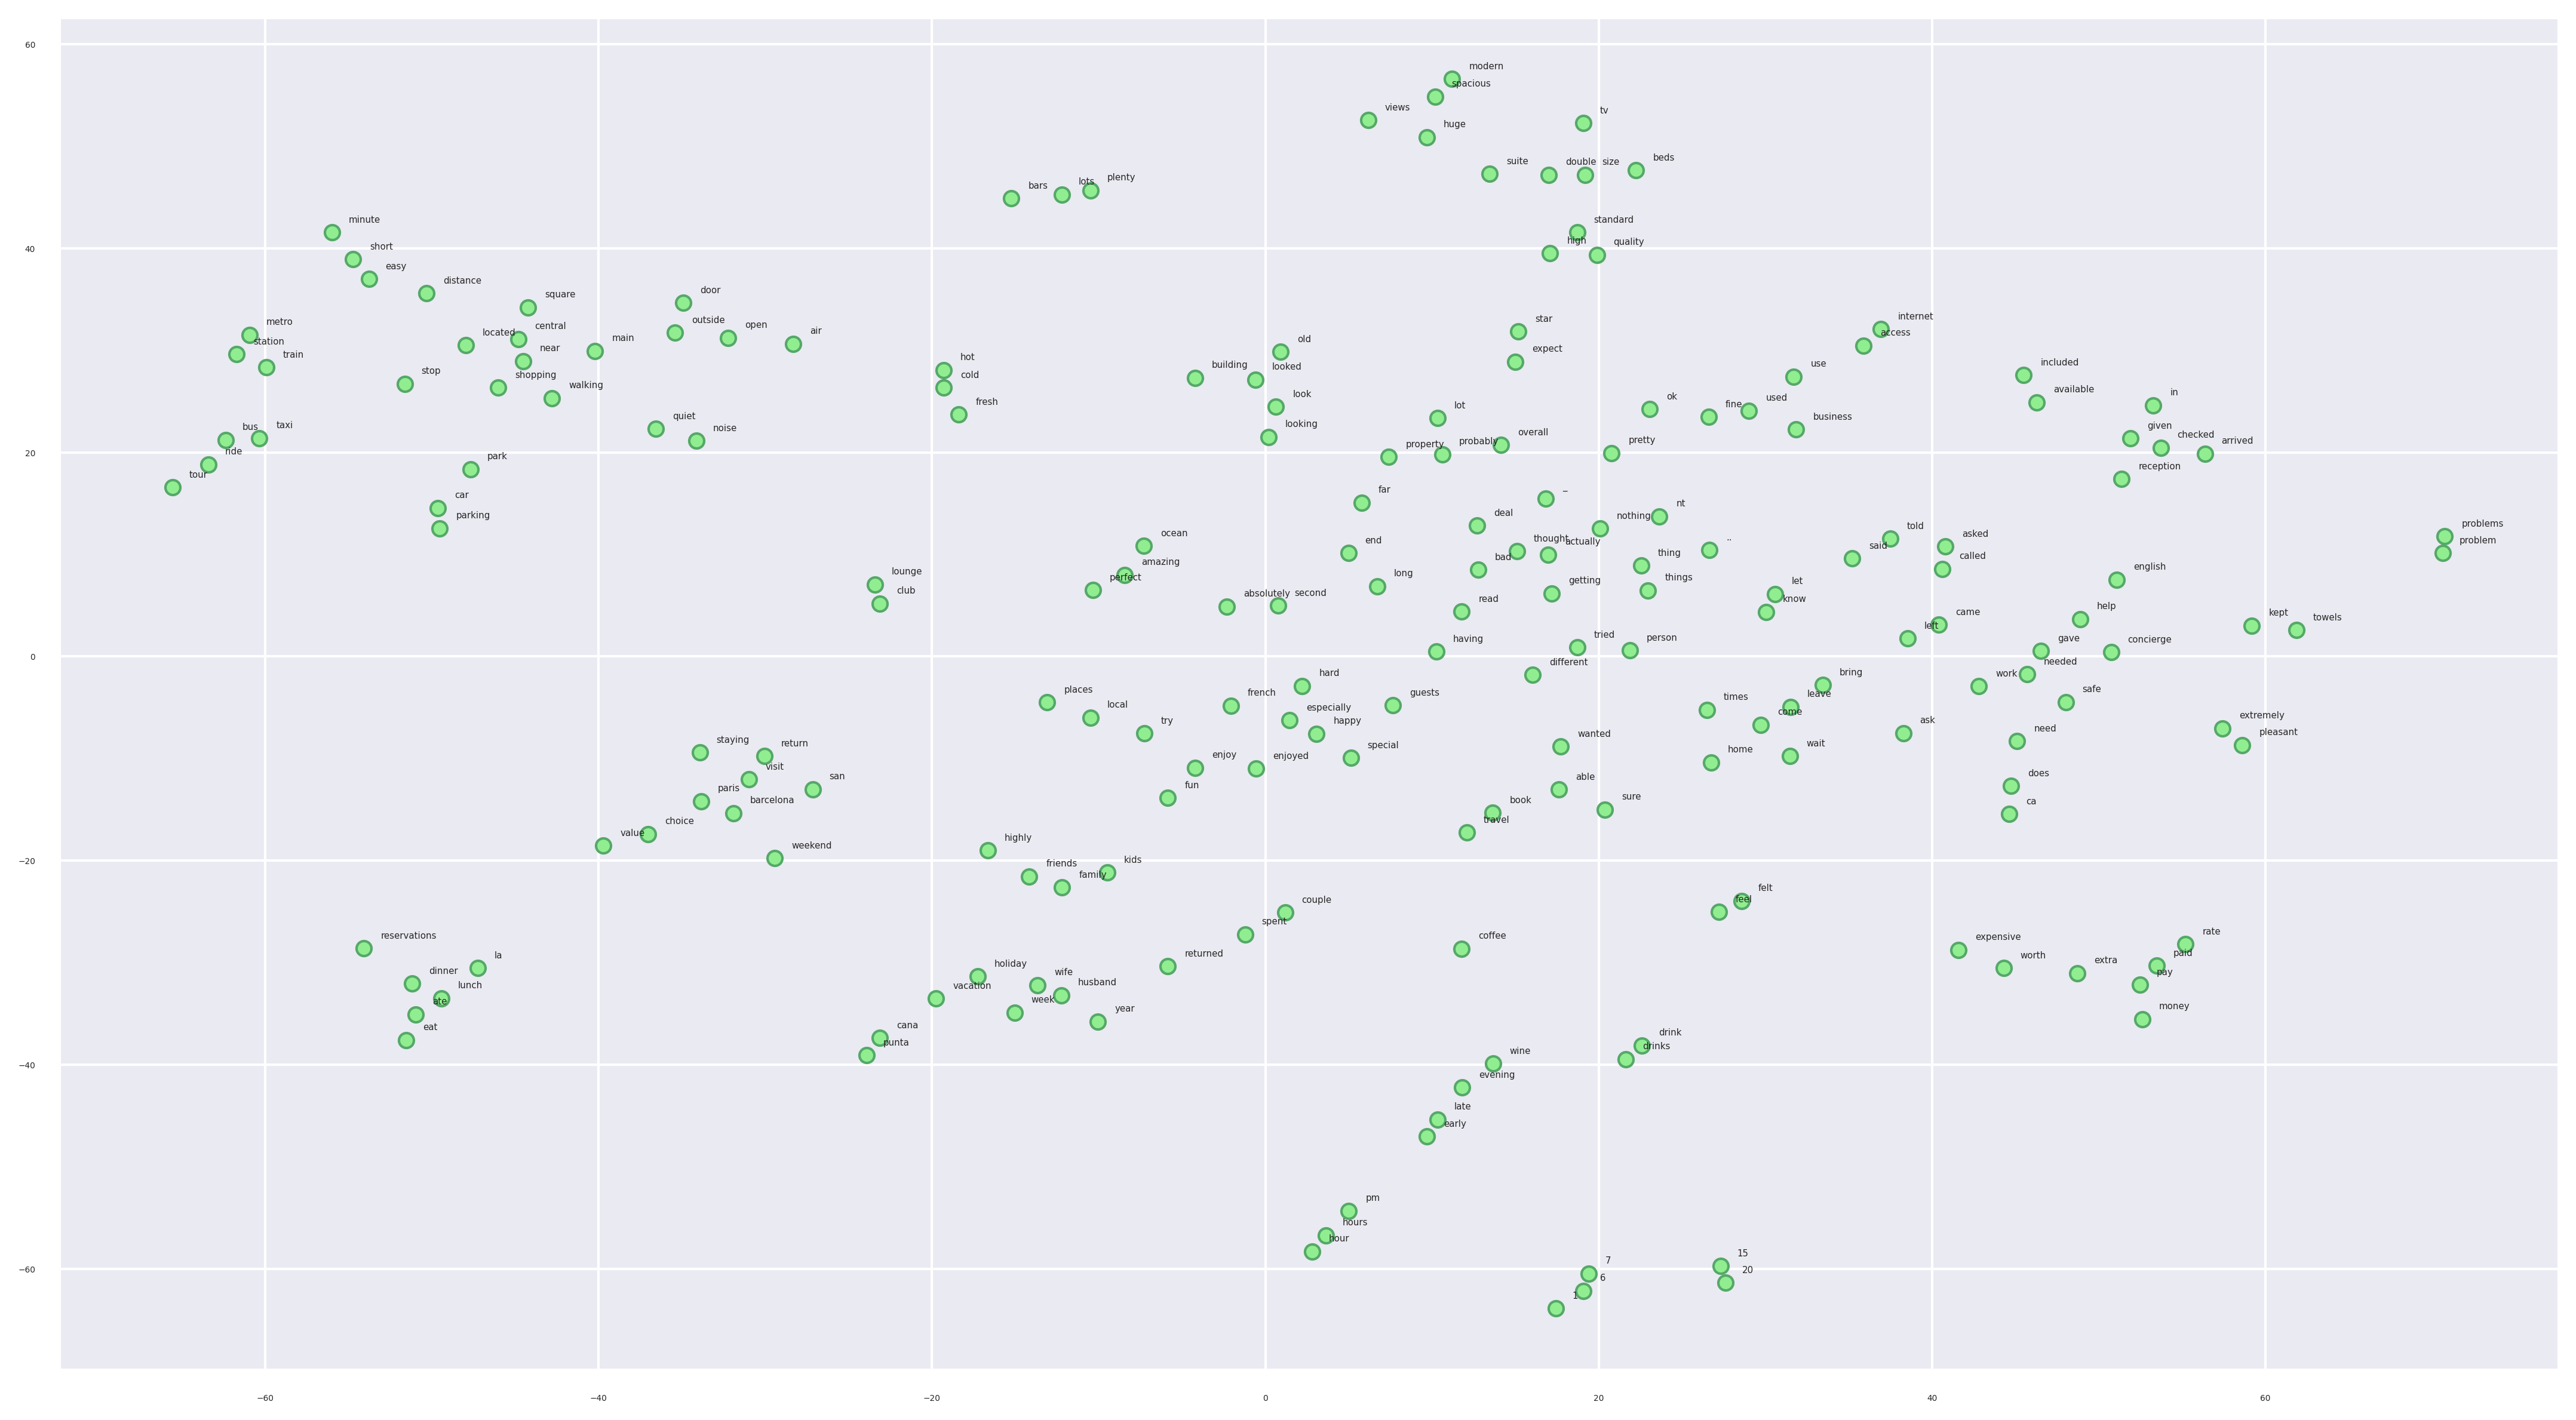

In [ ]:
words = w2vmodel_II.wv.index2word[100:300]      ## get the word forms of voculary sample
wvs = w2vmodel_II.wv[words]                     ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

The result is similar. Most of the groups from model I are visible again, but they are arranged in a different manner. But there are some differences, for example, the food and beverages are separated and the distances between many groups are different.

Now we analyse the most similar tokens for the token "hotel".

In [ ]:
# define function to get top n tokens of a word and visualize them

def display_closestwords_tsnescatterplot(model, word, size):

    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word, topn=80)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)

    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.figure(figsize=(15, 8))
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

<ipython-input-118-a794e5083c9e>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  arr = np.append(arr, np.array([model[word]]), axis=0)
<ipython-input-118-a794e5083c9e>:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  wrd_vector = model[wrd_score[0]]
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


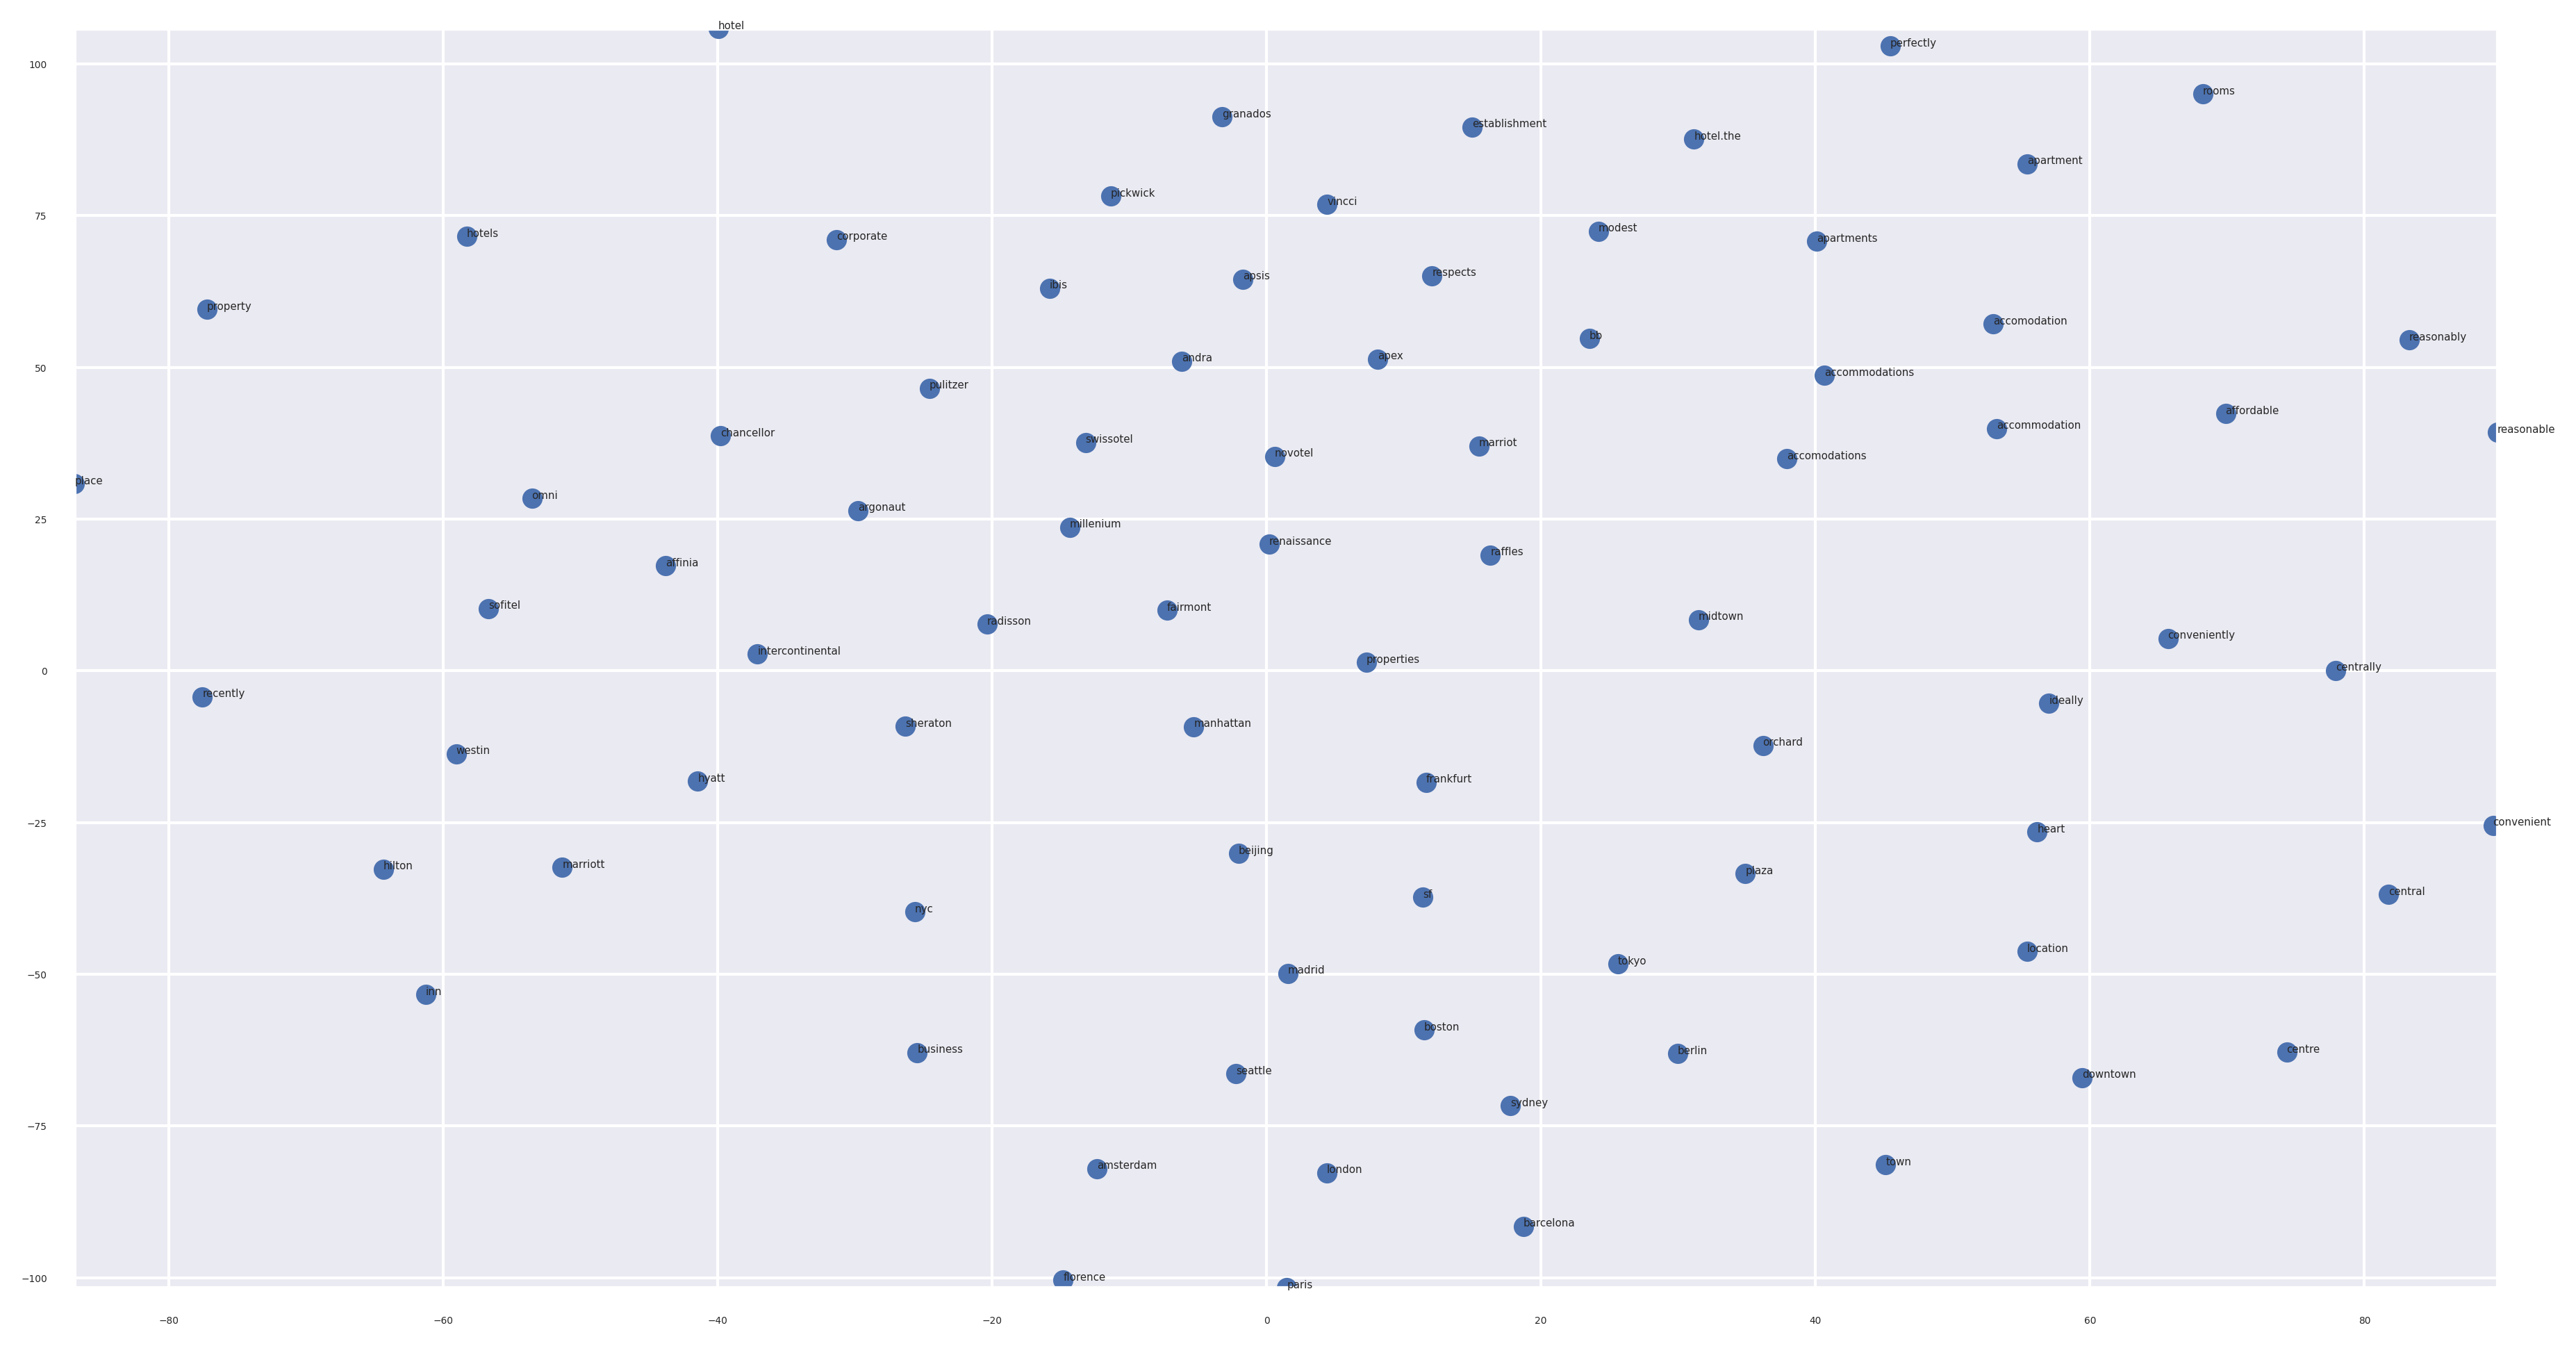

In [ ]:
display_closestwords_tsnescatterplot(w2vmodel_I, 'hotel', 300)

In this plot are as well some groups/topics visible, for example:

- left side: adjectives
- middle: Name of hotel (companys)
- top right corner: town / location
- bottom right corner: accommodation / building

Now we compare the results with model II.

<ipython-input-118-a794e5083c9e>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  arr = np.append(arr, np.array([model[word]]), axis=0)
<ipython-input-118-a794e5083c9e>:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  wrd_vector = model[wrd_score[0]]
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


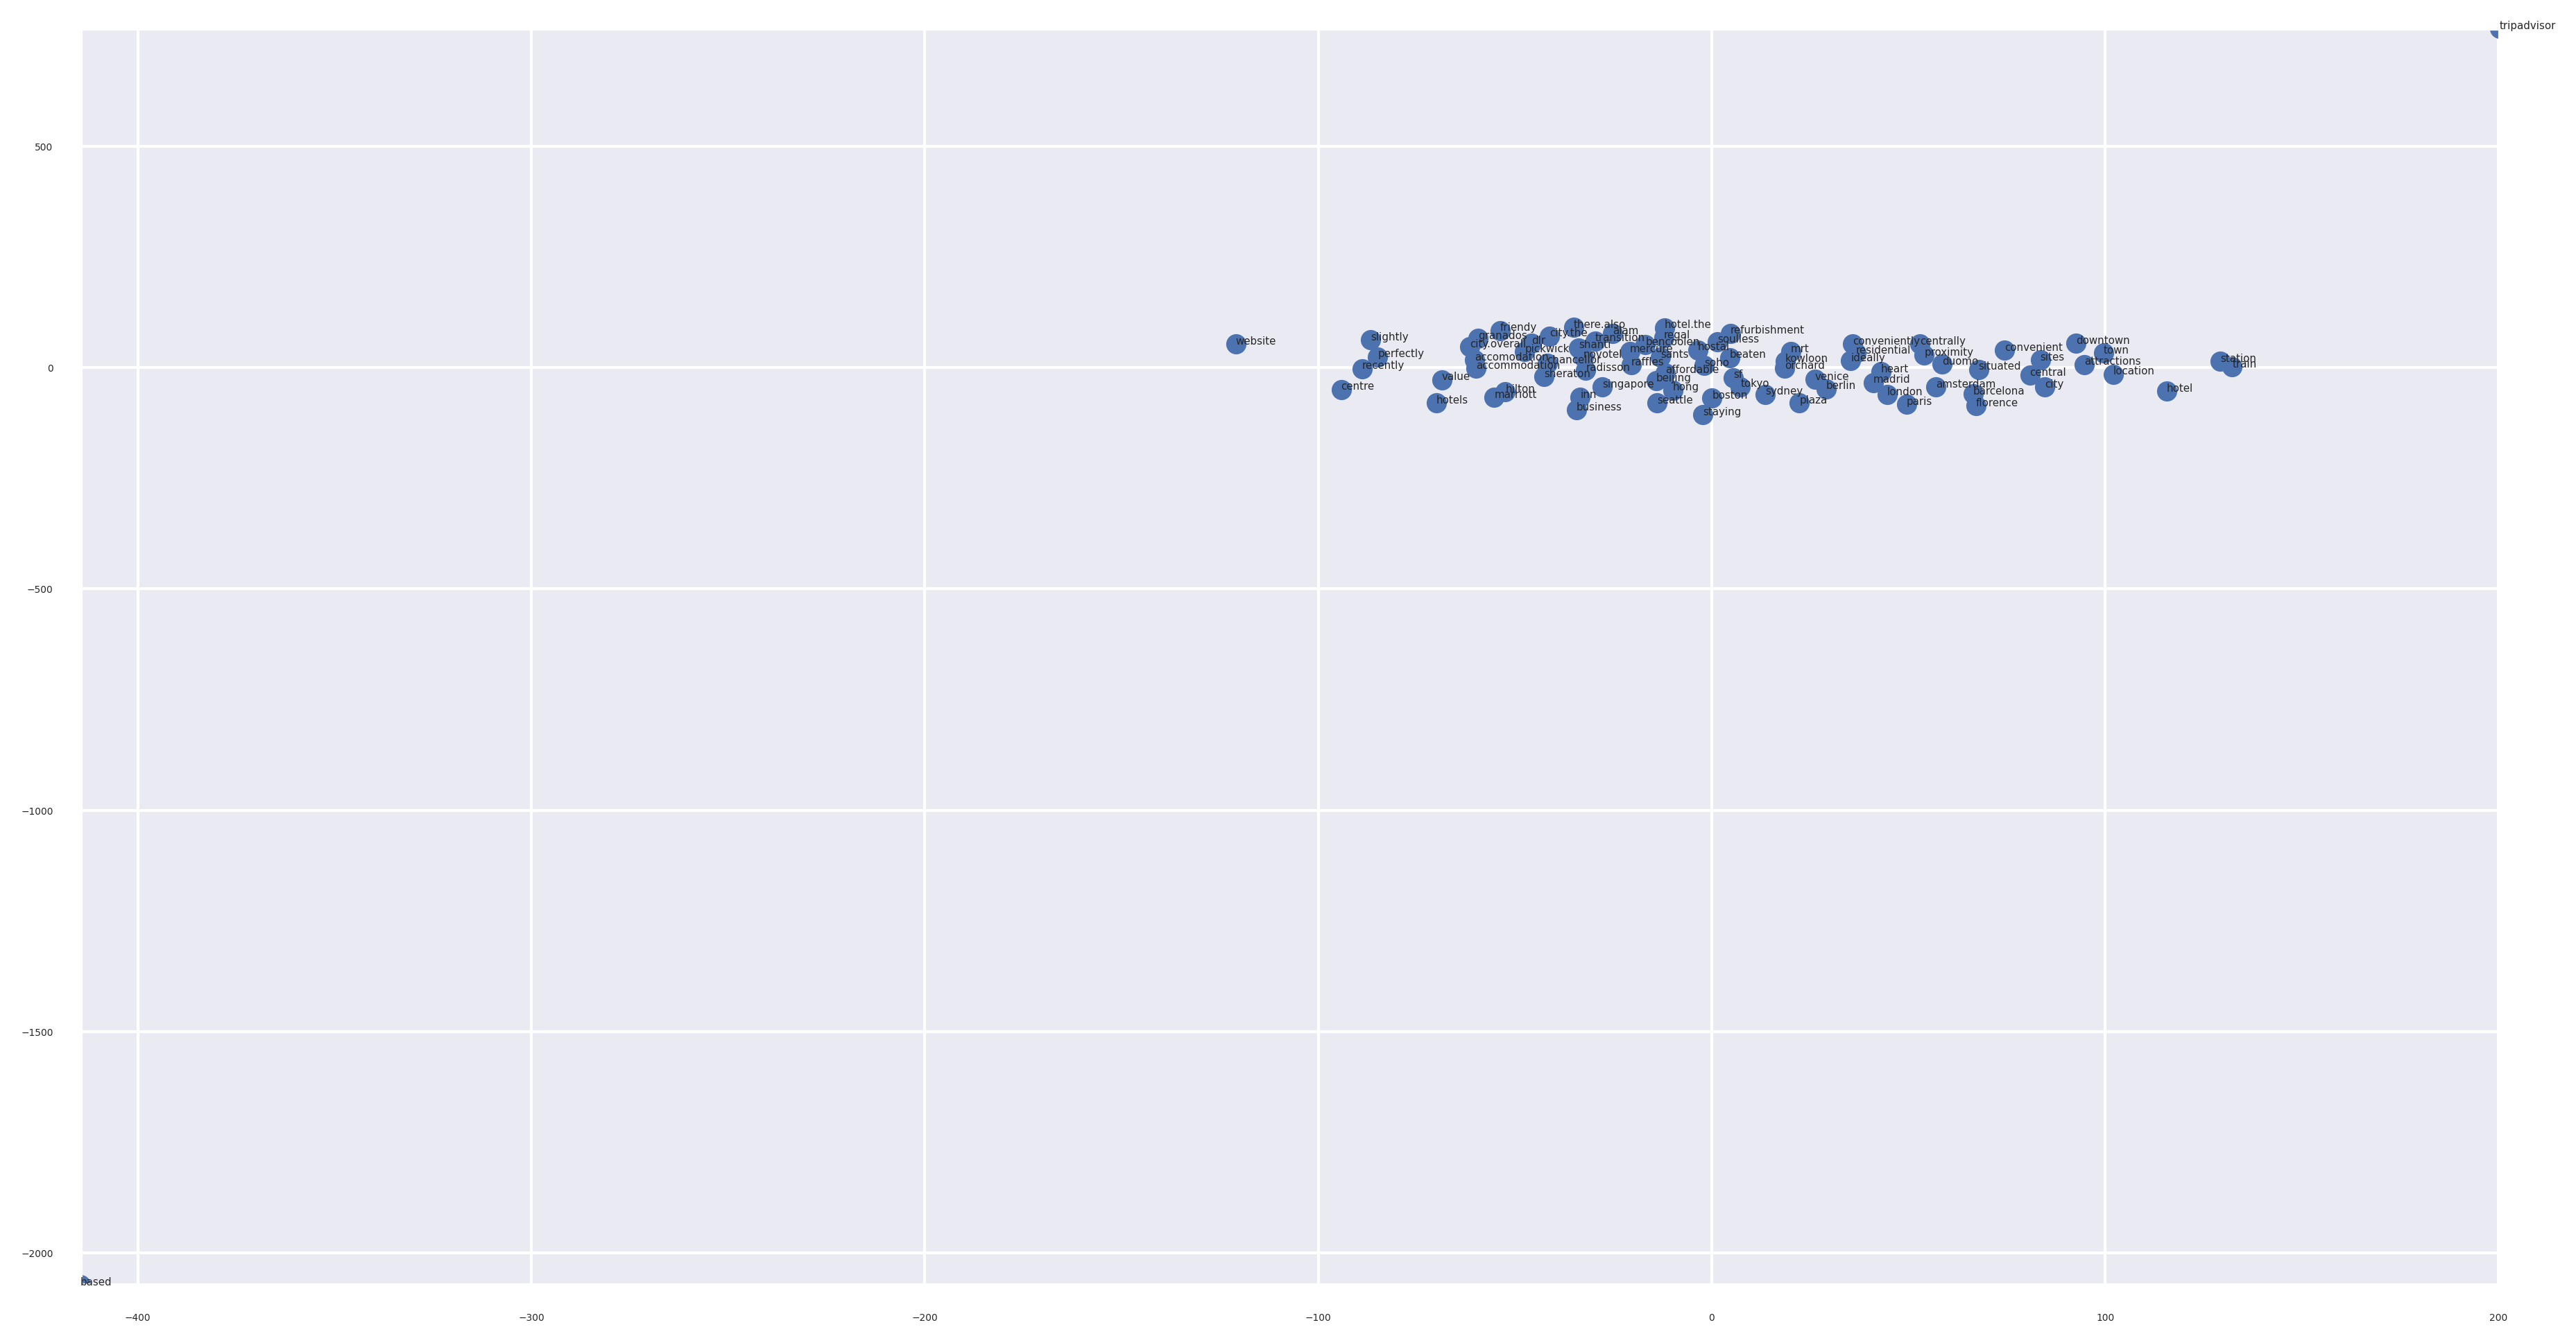

In [ ]:
display_closestwords_tsnescatterplot(w2vmodel_II, 'hotel', 300)

Again, most of the groups of model I are visible as well. But they are arranged in a different manner and in most cases, the distances are higher.

A comparison with the FastText model is in this case not meaningful, because it has another corpus of tokens.

## 7.&nbsp;Conclusion

**Recap of procedure**
1. Import a kaggle dataset concerning hotel reviews on trip advisor.
2. Preprocess the data, especially tokenize the review texts.
3. Fit three different models, two self-trained word2vec models with different window and one pre-trained FastText model.
4. Make a short exploratory text analysis to get an impression of the most important words.
5. Analyse similarity of words with different methods, for example the most similar words or visualisations of word embeddings.
6. Conclusion of the exercise.


**Most important insights**
- In general, the results of the most similar word analysis are plausibel.
- The self-trained models are more domain specific as the FastText model. This has been expected, because the FastText model is not trained on the review dataset.
- There are only small differences between the both self-trained word2vec models with the different window. Probably the difference between the window sizes have to be bigger, to see a remarkable difference in the results.
- A comparison of the most similar words according to the models with a list of synonyms according to WordNet is in this case not very useful.
- It seems that the similarity ratings tend to be lower for the word2vec models than for the FastText model. Surprisingly, this can be observed for all analysed words, even for the domain specific ones. There have to be done further analyses to get the reason for this finding and to find out, if this is only in this exercise the case or if it is a general statement.
- The visualisation of the word embeddings are plausibel. There are several groups visible, which could be explained.
- Again, there is no big difference between the two self-trained word2vec models.
